In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import nethelp as nh
import powerlaw
from collections import Counter
import community
import pickle
import graph_tool.all as gt

In [7]:
def extract_years(date_string):
    """
    Extracts start and end years from a string formatted as 'YYYY - YYYY'.

    This function looks for a date range in the format 'YYYY - YYYY' within the given string.
    If found, it extracts and returns the start year and end year as integers.

    Parameters
    ----------
    date_string : str
        The string that may contain a date range in the 'YYYY - YYYY' format.

    Returns
    -------
    tuple or None
        A tuple containing two integers: (start_year, end_year) if the pattern is found.
        Returns None if the pattern is not found.

    Examples
    --------
    >>> extract_years("Event happened between 1995 - 2000")
    (1995, 2000)

    >>> extract_years("No date here")
    None
    """
    # Define a regex pattern for 'YYYY - YYYY'
    pattern = r'(\d{4})\s*-\s*(\d{4})'
    
    # Search for the pattern in the input string
    match = re.search(pattern, date_string)
    
    if match:
        # Extract the start and end years from the match groups
        start_year = int(match.group(1))
        end_year = int(match.group(2))
        return start_year, end_year
    else:
        return None  # Return None if no match is found


In [8]:
def parse_training_data(link_attributes, institution, order):
    """
    Parses a list of educational or training attributes to extract relevant details such as 
    degree level, subject, start year, end year, and awards. The function handles various 
    formats and patterns in the input data and applies specific rules based on the presence 
    of keywords like 'residency', 'fellowship', and 'class of', and adjusts for special cases 
    such as osteopathic institutions ('DO' degrees).

    Parameters:
    -----------
    link_attributes : list of str
        A list containing details about an individual's training or education at a particular 
        institution. Each entry can represent degree level, subject, year range, or other details.
        
    institution : str
        The name of the institution where the training or education took place. This is 
        checked for keywords such as 'osteopath' to infer specific degree levels like 'DO'.
        
    order : int
        An integer representing the order of the training or education in the individual's 
        trajectory, used for tracking sequence in a graph or timeline.

    Returns:
    --------
    dict
        A dictionary with the following keys:
        - 'level' : str or None
            The training level or degree (e.g., 'MD', 'PhD', 'Fellowship', 'Residency').
        - 'order' : int
            The order of the training or education, as passed in the input.
        - 'subject' : str or None
            The subject or field of study (e.g., 'Biology', 'Cardiology').
        - 'start' : int or None
            The start year of the training/education.
        - 'end' : int or None
            The end year of the training/education.
        - 'award' : str or None
            Any awards or honors mentioned (e.g., 'Cum Laude', 'Honors').

    Example:
    --------
    >>> parse_training_data(['Fellowship', 'Cardiology', '2005 - 2007'], 'Harvard University', 1)
    {'level': 'fellowship', 'order': 1, 'subject': 'cardiology', 'start': 2005, 'end': 2007, 'award': None}

    >>> parse_training_data(['Class of 2005'], 'NYIT College Of Osteopathic Medicine', 2)
    {'level': 'do', 'order': 2, 'subject': None, 'start': 2001, 'end': 2005, 'award': None}
    """
    level = None
    subject = None
    start_date = None
    end_date = None
    award = None 
    
    l = -1
    for entry in link_attributes:
        
        # training level 
        l = l + 1
        result = extract_years(entry)
        if 'class of' in entry.lower():
            level = 'md'
            # topic = None
            start_date = int(entry.split()[-1]) - 4
            end_date = int(entry.split()[-1])

        elif l == 0:

            if 'residency' in entry.lower():
                level = 'residency' 
                # start = start = int(entry.split()[-3]) # this needs to be its own if clause becuase the date is not going to be in the same entry as residency
                
            elif 'postdoc' in entry.lower().replace('-', ''):
                level = 'postdoc'
            
            elif 'fellowship' in entry.lower(): 
                level = 'fellowship'
            
            elif 'intern' in entry.lower():
                level = 'internship'

            elif 'intern' in entry.lower():
                level = 'internship'

            elif 'phd' in entry.lower().replace('.', ''):
                level = 'phd'

            elif 'mph' in entry.lower().replace('.', ''):
                level = 'mph'

            elif 'ba' in entry.lower().replace('.', ''):
                level = 'ba'
            
            elif 'bs' in entry.lower().replace('.', ''):
                level = 'bs'
            
            else:
                level = entry.lower().replace('.','')
        
        elif 'do' == entry.lower().replace('.',''):
            level = 'do'
        # start and end dates
        elif result:
            start_date, end_date = result
        
        # awards
        elif 'cum' in entry.lower():
            award = entry.lower()
        elif 'honor' in entry.lower() or 'honour' in entry.lower():
            award = entry.lower()

        # assume anything else is subject 
        else:
            subject = entry.lower()

    if 'osteopath' in institution.lower():
        level = 'do'
        
    parsed_dict = {
        'level': level,
        'order': order,
        'subject': subject,
        'start': start_date,
        'end': end_date,
        'award': award
    }
    return parsed_dict


### Creating temporal edge list and plotting for cardiology

In [5]:
import pandas as pd
i = -1
G = nx.Graph()
g_inst = nx.DiGraph()
tdf = pd.DataFrame({'node_u': [], 'node_v': [], 'timestamp': []})
edge_count = 0
institutions = set()
errors = 0

while i < 38970:  # total number of files
    i += 1  # increment counter
    try:
        filepath = f'../../physician_trajectories/data/card/{i}.json'  # construct filepath
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)  # load JSON as dict
        except FileNotFoundError as e:
            print(f"[Error] File not found: {filepath}")
            errors += 1
            continue
        except json.JSONDecodeError as e:
            print(f"[Error] JSON decode error in file: {filepath}. Error: {e}")
            errors += 1
            continue

        try:
            G.add_node(
                i,
                bipartite=0,
                first_name=data[str(i)]['first_name'],
                last_name=data[str(i)]['last_name'],
                specialty=data[str(i)]['specialty'],
                sub_specialty=data[str(i)]['sub_specialty'],
                office=data[str(i)]['office'],
                job_titles=data[str(i)]['job_titles'],
                awards=data[str(i)]['awards'],
            )
        except KeyError as e:
            print(f"[Error] Missing key in data for node {i}: {e}")
            errors += 1
            continue

        try:
            if data.get(str(i)).get('training'):
                for keys, vals in data.get(str(i)).get('training').items():
                    inst = list(vals.keys())[0]
                    institutions.add(inst)
                    parsed_dict = parse_training_data(
                        link_attributes=list(vals.values())[0], institution=inst, order=int(keys)
                    )
                    G.add_node(inst, bipartite=1)
                    G.add_edge(
                        i,
                        inst,
                        level=parsed_dict['level'],
                        order=parsed_dict['order'],
                        subject=parsed_dict['subject'],
                        start=parsed_dict['start'],
                        end=parsed_dict['end'],
                        award=parsed_dict['award'],
                    )
                for line in data.get(str(i)).get('hospital', []):
                    institutions.add(line)
                    G.add_node(line, bipartite=1)
                    G.add_edge(i, line)
        except Exception as e:
            print(f"[Error] Error processing training or hospital data for node {i}: {e}")
            errors += 1
            continue

        num_insts = len(data[str(i)]['training'])
        try:
            if num_insts > 1:
                training_data = data[str(i)]['training']
                iterator = [[im, im + 1] for im in range(num_insts-1)]
                node_u, node_v, timestamp = [], [], []
                for ix in iterator:
                    link_attrs_0 = list(list(training_data.values())[ix[0]].values())[0]
                    inst_0 = list(list(training_data.values())[ix[0]].keys())[0]
                    parsed_dict_0 = parse_training_data(link_attrs_0, inst_0, 0)
                    link_attrs_1 = list(list(training_data.values())[ix[1]].values())[0]
                    inst_1 = list(list(training_data.values())[ix[1]].keys())[0]
                    parsed_dict_1 = parse_training_data(link_attrs_1, inst_1, 1)
                    if parsed_dict_1['end']:
                        timestamp.append(parsed_dict_1['end'])
                        node_u.append(inst_1)
                        node_v.append(inst_0)
                df = pd.DataFrame({'node_u': node_u, 'node_v': node_v, 'timestamp': timestamp})
                tdf = pd.concat([tdf, df], ignore_index=True)
        except Exception as e:
            print(f"[Error] Error processing training timeline for node {i}: {e}")
            errors += 1
            continue

    except Exception as e:
        print(f"[Error] Unexpected error in main loop for node {i}: {e}")
        errors += 1


[Error] Unexpected error in main loop for node 0: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 804: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 963: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1046: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1127: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1138: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1290: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1432: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1434: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1470: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for nod

In [7]:
print(errors)
tdf

431


,node_u,node_v,timestamp
0,New York-Presbyterian Brooklyn Methodist Hospital,New York-Presbyterian Brooklyn Methodist Hospital,2012.0
1,Indiana University School of Medicine,New York-Presbyterian Brooklyn Methodist Hospital,2009.0
2,St. George's University School of Medicine,Indiana University School of Medicine,2006.0
3,University of Missouri-Kansas City School of M...,University of Missouri-Kansas City School of M...,2015.0
4,Mayo Clinic College of Medicine and Science (R...,University of Missouri-Kansas City School of M...,2014.0
...,...,...,...
86095,Mercy Hospital and Medical Center,McGaw Medical Center of Northwestern University,1972.0
86096,University of Zagreb Faculty of Medicine,Mercy Hospital and Medical Center,1970.0
86097,Seton Hall University-Hackensack Meridian Scho...,Icahn School of Medicine at Mount Sinai/Mount ...,2006.0
86098,Drexel University College of Medicine/Hahneman...,Seton Hall University-Hackensack Meridian Scho...,2003.0


In [12]:
list(tdf['node_u'].sort_values().unique())

[' Institute of Medical Sciences, Banaras Hindu University, Varanasi, INDIA ',
 ' University of Cincinnati Medical Center/College of Medicine University of Cincinnati Medical Center/College of Medicine',
 '"Aieti" Highest Medical School',
 "(King's College London - School of Medicine)",
 'A. T. Still University Kirksville College of Osteopathic Medicine',
 'A.T. Still University, School of Osteopathic Medicine in Arizona',
 'AC Logan Memorial Hospital',
 'AUC School of Medicine',
 'Aarhus University Faculty of Medicine',
 'Abbott-Northwestern Hospital',
 'Abbott-Northwestern Hospital/Allina Health System',
 'Abilene Christian University',
 'Abington Memorial Hospital',
 'Abrazo Health Network',
 'Addis Ababa University Faculty of Medicine',
 'Adelphi University',
 'Adichunchanagiri Institute of Medical Sciences',
 'AdventHealth Florida (East Orlando)',
 'AdventHealth Florida (Orlando)',
 'Adventist Health Glendale',
 'Adventist Health Portland',
 'Adventist Health White Memorial',
 'Ad

In [14]:
from collections import Counter

dict(sorted(dict(Counter(tdf['node_u'])).items()))

{' Institute of Medical Sciences, Banaras Hindu University, Varanasi, INDIA ': 1,
 ' University of Cincinnati Medical Center/College of Medicine University of Cincinnati Medical Center/College of Medicine': 1,
 '"Aieti" Highest Medical School': 1,
 "(King's College London - School of Medicine)": 7,
 'A. T. Still University Kirksville College of Osteopathic Medicine': 83,
 'A.T. Still University, School of Osteopathic Medicine in Arizona': 4,
 'AC Logan Memorial Hospital': 8,
 'AUC School of Medicine': 1,
 'Aarhus University Faculty of Medicine': 1,
 'Abbott-Northwestern Hospital': 23,
 'Abbott-Northwestern Hospital/Allina Health System': 1,
 'Abilene Christian University': 1,
 'Abington Memorial Hospital': 44,
 'Abrazo Health Network': 1,
 'Addis Ababa University Faculty of Medicine': 14,
 'Adelphi University': 1,
 'Adichunchanagiri Institute of Medical Sciences': 8,
 'AdventHealth Florida (East Orlando)': 1,
 'AdventHealth Florida (Orlando)': 4,
 'Adventist Health Glendale': 1,
 'Adve

#### attempting deduplication with rapidfuzz

Things I have to deal with 
1.  'Icahn School of Medicine at Mount Sinai (Bronx)',
 'Icahn School of Medicine at Mount Sinai (Cabrini)',
 'Icahn School of Medicine at Mount Sinai (Elmhurst)',
2.  'Alexandria University': 1,
 'Alexandria University Faculty of Medicine': 8,
 'Alexandria University, Faculty of Medicine ': 1,
3. 

In [81]:
from rapidfuzz import fuzz
print(fuzz.ratio('Alexandria University Faculty of Medicine', 'Alexandria University, Faculty of Medicine '))
print(fuzz.ratio('Alexandria University Faculty of Medicine', 'Alexandria University'))
print(fuzz.ratio('Alexandria University Faculty of Medicine', 'Icahn School of Medicine at Mount Sinai (Bronx)'))
print(fuzz.ratio('Icahn School of Medicine at Mount Sinai (Cabrini)', 'Icahn School of Medicine at Mount Sinai (Bronx)'))



97.61904761904762
67.74193548387098
38.63636363636363
91.66666666666666


In [83]:
print(fuzz.token_set_ratio('Alexandria University Faculty of Medicine', 'Alexandria University, Faculty of Medicine '))
print(fuzz.token_set_ratio('Alexandria University Faculty of Medicine', 'Alexandria University'))
print(fuzz.token_set_ratio('Alexandria University Faculty of Medicine', 'Icahn School of Medicine at Mount Sinai (Bronx)'))
print(fuzz.token_set_ratio('Icahn School of Medicine at Mount Sinai (Cabrini)', 'Icahn School of Medicine at Mount Sinai (Bronx)'))

98.79518072289157
100.0
50.0
91.66666666666667


In [86]:
tdf

,node_u,node_v,timestamp,time_elapsed,time_bin
0,Massachusetts General Hospital,Brandeis University,1997.0,55.0,0.0
1,Brigham and Women's Hospital,Massachusetts General Hospital,1993.0,51.0,0.0
2,Albert Einstein College of Medicine,Brigham and Women's Hospital,1991.0,49.0,0.0
3,Albert Einstein College of Medicine,Albert Einstein College of Medicine,1991.0,49.0,0.0
4,Wesleyan Universtity,Albert Einstein College of Medicine,1982.0,40.0,0.0
...,...,...,...,...,...
86095,University of Pennsylvania Health System,Other Training,2013.0,71.0,0.0
86096,Icahn School of Medicine at Mount Sinai/Mount ...,University of Pennsylvania Health System,2008.0,66.0,0.0
86097,Central University of Venezuela,Icahn School of Medicine at Mount Sinai/Mount ...,2003.0,61.0,0.0
86098,Corewell Health East Beaumont (Royal Oak),Corewell Health East Beaumont (Royal Oak),1992.0,50.0,0.0


In [102]:
unique_institutions

array(['Brandeis University', 'Massachusetts General Hospital',
       "Brigham and Women's Hospital", ..., 'Shorter University',
       'University of Nottingham Medical School', 'Kemerovo Med Acad'],
      dtype=object)

In [100]:
unique_institutions = pd.concat([tdf['node_v'], tdf['node_u']]).unique()
len(unique_institutions)

3828

In [105]:
from rapidfuzz import process

tdf
# Function to deduplicate a list
def deduplicate_names(names, threshold=85):
    unique_groups = []  # Groups of similar names
    seen = set()        # Track processed names

    for name in names:
        if name in seen:
            continue  # Skip already processed names

        # Find matches for the current name in the remaining list
        matches = process.extract(
            name, names, scorer=fuzz.ratio, score_cutoff=threshold
        )
        # Add matches to a group
        group = [match[0] for match in matches]
        unique_groups.append(group)

        # Mark all matches as processed
        seen.update(group)

    # Deduplicate: Pick one representative name per group
    deduplicated = [group[0] for group in unique_groups]
    return deduplicated, unique_groups


In [112]:
deduplicated, groups = deduplicate_names(unique_institutions, threshold=85)

print("Deduplicated Names:")
sorted(deduplicated)  # Print deduplicated)

Deduplicated Names:


[' Institute of Medical Sciences, Banaras Hindu University, Varanasi, INDIA ',
 ' University of Cincinnati Medical Center/College of Medicine University of Cincinnati Medical Center/College of Medicine',
 '"Aieti" Highest Medical School',
 "(King's College London - School of Medicine)",
 'A. T. Still University Kirksville College of Osteopathic Medicine',
 'A.T. Still University, School of Osteopathic Medicine in Arizona',
 'AC Logan Memorial Hospital',
 'AMITA Health Saint Joseph Hospital',
 'Abbott Northwestern Hospital',
 'Abbott-Northwestern Hospital/Allina Health System',
 'Abilene Christian University',
 'Abrazo Arizona Heart Hospital',
 'Abrazo Health Network',
 'Addis Ababa University Faculty of Medicine',
 'Adelphi',
 'Adelphi University',
 'Adichunchanagiri Institute of Medical Sciences',
 'AdventHealth Florida',
 'AdventHealth Florida (Orlando)',
 'Adventist Health Glendale',
 'Adventist Health Portland',
 'Adventist Health White Memorial',
 'Adventist Hinsdale Hospital',
 '

In [113]:
print("\nGroups of Similar Names:")
for group in groups:
    print(group)


Groups of Similar Names:
['Brandeis University', 'Bradley University']
['Massachusetts General Hospital', 'Massachusetts General Hospital ', ' Massachusetts General Hospital']
["Brigham and Women's Hospital", 'Brigham and Womens Hospital', "Brigham and Women's Hospital A", 'Brigham and Women’s Hospital']
['Albert Einstein College of Medicine', 'Albert Einstein Coll of Medicine']
['Cook County Health and Hospitals System']
['Allegheny Health Network Medical Education Consortium (AGH)', 'Allegheny Health Network Medical Education Consortium (WPH)']
['Rutgers Health/Robert Wood Johnson Medical School', 'Rutgers Robert Wood Johnson Medical School', 'Rutgers, Robert Wood Johnson Medical School']
['MedStar Health/Georgetown-Washington Hospital Center', 'MedStar Health/Georgetown-Washington Hospital', 'MedStar Health/Washington Hospital Center']
['Loyola University Medical Center', 'Columbia University Medical Center', 'Boston University Medical Center', 'Baylor University Medical Center', '

In [ ]:
tdf['time_elapsed'] = tdf['timestamp'] - tdf['timestamp'].min()
bin_size = 1
tdf["time_bin"] = (tdf['time_elapsed'] // bin_size) * bin_size
tdf

,node_u,node_v,timestamp,time_elapsed
0,New York-Presbyterian Brooklyn Methodist Hospital,New York-Presbyterian Brooklyn Methodist Hospital,2012.0,70.0
1,Indiana University School of Medicine,New York-Presbyterian Brooklyn Methodist Hospital,2009.0,67.0
2,St. George's University School of Medicine,Indiana University School of Medicine,2006.0,64.0
3,University of Missouri-Kansas City School of M...,University of Missouri-Kansas City School of M...,2015.0,73.0
4,Mayo Clinic College of Medicine and Science (R...,University of Missouri-Kansas City School of M...,2014.0,72.0
...,...,...,...,...
86095,Mercy Hospital and Medical Center,McGaw Medical Center of Northwestern University,1972.0,30.0
86096,University of Zagreb Faculty of Medicine,Mercy Hospital and Medical Center,1970.0,28.0
86097,Seton Hall University-Hackensack Meridian Scho...,Icahn School of Medicine at Mount Sinai/Mount ...,2006.0,64.0
86098,Drexel University College of Medicine/Hahneman...,Seton Hall University-Hackensack Meridian Scho...,2003.0,61.0


In [43]:
aggregate_counts = tdf["time_bin"].value_counts().sort_index()
aggregate_counts

time_bin
0.0       1
1.0       4
2.0       1
3.0       4
4.0       2
       ... 
79.0    625
80.0    477
81.0    387
82.0    159
83.0      4
Name: count, Length: 84, dtype: int64

In [44]:
from matplotlib import rc
rc('axes', axisbelow=True)
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

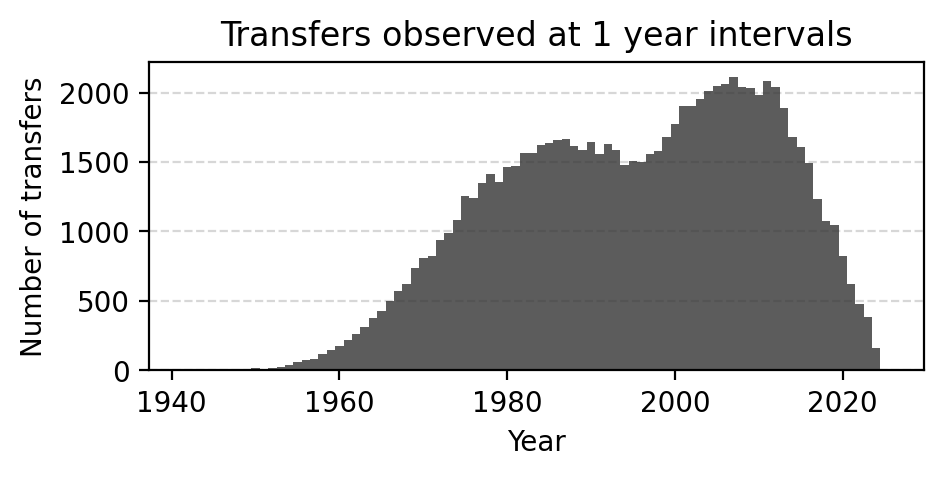

In [45]:
fig, ax = plt.subplots(1,1,figsize=(5,2),dpi=200)

ax.bar(aggregate_counts.index + tdf['timestamp'].min(), aggregate_counts.values, width=bin_size, color='.2', alpha=0.8)

ax.grid(axis="y", linestyle="--", alpha=0.5)
# Set x-ticks at absolute 24-hour intervals
start_time = aggregate_counts.index.min()
end_time = aggregate_counts.index.max()

# Generate 24-hour spaced timestamps
# tick_positions = range(start_time, end_time + 1, 24 * 3600)  # Step by 24 hours (in seconds)
#tick_labels = ['Day %i'%i for i in range(1,len(tick_positions)+1)]

# Set ticks and labels
# ax.set_xticks(tick_positions)
# ax.set_xticklabels(tick_labels)

ax.set_title("Transfers observed at %.0f year intervals"%(bin_size))
ax.set_xlabel("Year")
ax.set_ylabel("Number of transfers")

plt.show()

### Creating temporal edge list and plotting for all specialties

In [5]:
import os
import json
import pandas as pd

base_path = '../../physician_trajectories/data'
folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

In [9]:
folders

['neurosurgery',
 'medical_genetics',
 'card',
 'endocrinology',
 'allergy',
 'geriatrics',
 'int_radiology',
 'obgyn',
 'child_neurology',
 'gastroenterology',
 'ophthalmology',
 'colorectal_surgery',
 'dermatology',
 'psychiatry',
 'hematology']

In [10]:
import os
import json
import pandas as pd

base_path = '../../physician_trajectories/data'
folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

errors = 0
tdf_dict = {}  # Dictionary to store tdf for each folder

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    tdf = pd.DataFrame({'node_u': [], 'node_v': [], 'timestamp': []})
    print(f"Processing folder: {folder}")
    
    # Iterate through files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            try:
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as f:
                    data = json.load(f)
                
                # Assuming the file name format includes the ID
                i = int(file_name.split('.')[0])

                num_insts = len(data[str(i)]['training'])
                if num_insts > 1:
                    training_data = data[str(i)]['training']
                    iterator = [[im, im + 1] for im in range(num_insts - 1)]
                    node_u, node_v, timestamp = [], [], []
                    for ix in iterator:
                        link_attrs_0 = list(list(training_data.values())[ix[0]].values())[0]
                        inst_0 = list(list(training_data.values())[ix[0]].keys())[0]
                        parsed_dict_0 = parse_training_data(link_attrs_0, inst_0, 0)
                        link_attrs_1 = list(list(training_data.values())[ix[1]].values())[0]
                        inst_1 = list(list(training_data.values())[ix[1]].keys())[0]
                        parsed_dict_1 = parse_training_data(link_attrs_1, inst_1, 1)
                        if parsed_dict_1['end']:
                            timestamp.append(parsed_dict_1['end'])
                            node_u.append(inst_1)
                            node_v.append(inst_0)
                    df = pd.DataFrame({'node_u': node_u, 'node_v': node_v, 'timestamp': timestamp})
                    tdf = pd.concat([tdf, df], ignore_index=True)
            except Exception as e:
                print(f"[Error] Error processing file {file_name} in folder {folder}: {e}")
                errors += 1
                continue
    
    tdf_dict[folder] = tdf  # Store the tdf for this folder
    print(f"Completed processing folder: {folder}. Total rows in tdf: {len(tdf)}")

# Example: Access the tdf for a specific folder
# print(tdf_dict['card'])



Processing folder: neurosurgery
[Error] Error processing file failed_urls25.json in folder neurosurgery: invalid literal for int() with base 10: 'failed_urls25'
[Error] Error processing file failed_urls109.json in folder neurosurgery: invalid literal for int() with base 10: 'failed_urls109'
[Error] Error processing file 4267.json in folder neurosurgery: string indices must be integers, not 'str'
[Error] Error processing file 791.json in folder neurosurgery: string indices must be integers, not 'str'
[Error] Error processing file failed_urls72.json in folder neurosurgery: invalid literal for int() with base 10: 'failed_urls72'
[Error] Error processing file failed_urls64.json in folder neurosurgery: invalid literal for int() with base 10: 'failed_urls64'
[Error] Error processing file failed_urls148.json in folder neurosurgery: invalid literal for int() with base 10: 'failed_urls148'
[Error] Error processing file failed_urls33.json in folder neurosurgery: invalid literal for int() with ba

In [51]:
tdf_dict['neurosurgery']

,node_u,node_v,timestamp
0,National Capital Consortium,National Capital Consortium,1972.0
1,National Capital Consortium,National Capital Consortium,1968.0
2,Albany Medical College,National Capital Consortium,1967.0
3,University of Texas Health Science Center San ...,University of Washington,2003.0
4,University of Texas Health Science Center San ...,University of Texas Health Science Center San ...,1999.0
...,...,...,...
16407,Johns Hopkins University,University of California San Diego School of M...,2014.0
16408,Duke University Hospital,Duke University Hospital,2003.0
16409,Duke University School of Medicine,Duke University Hospital,2002.0
16410,NYU Grossman School of Medicine,NYU Grossman School of Medicine,2006.0


In [56]:
for i, folder in enumerate(folders):
    print(i//3, i%3)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2


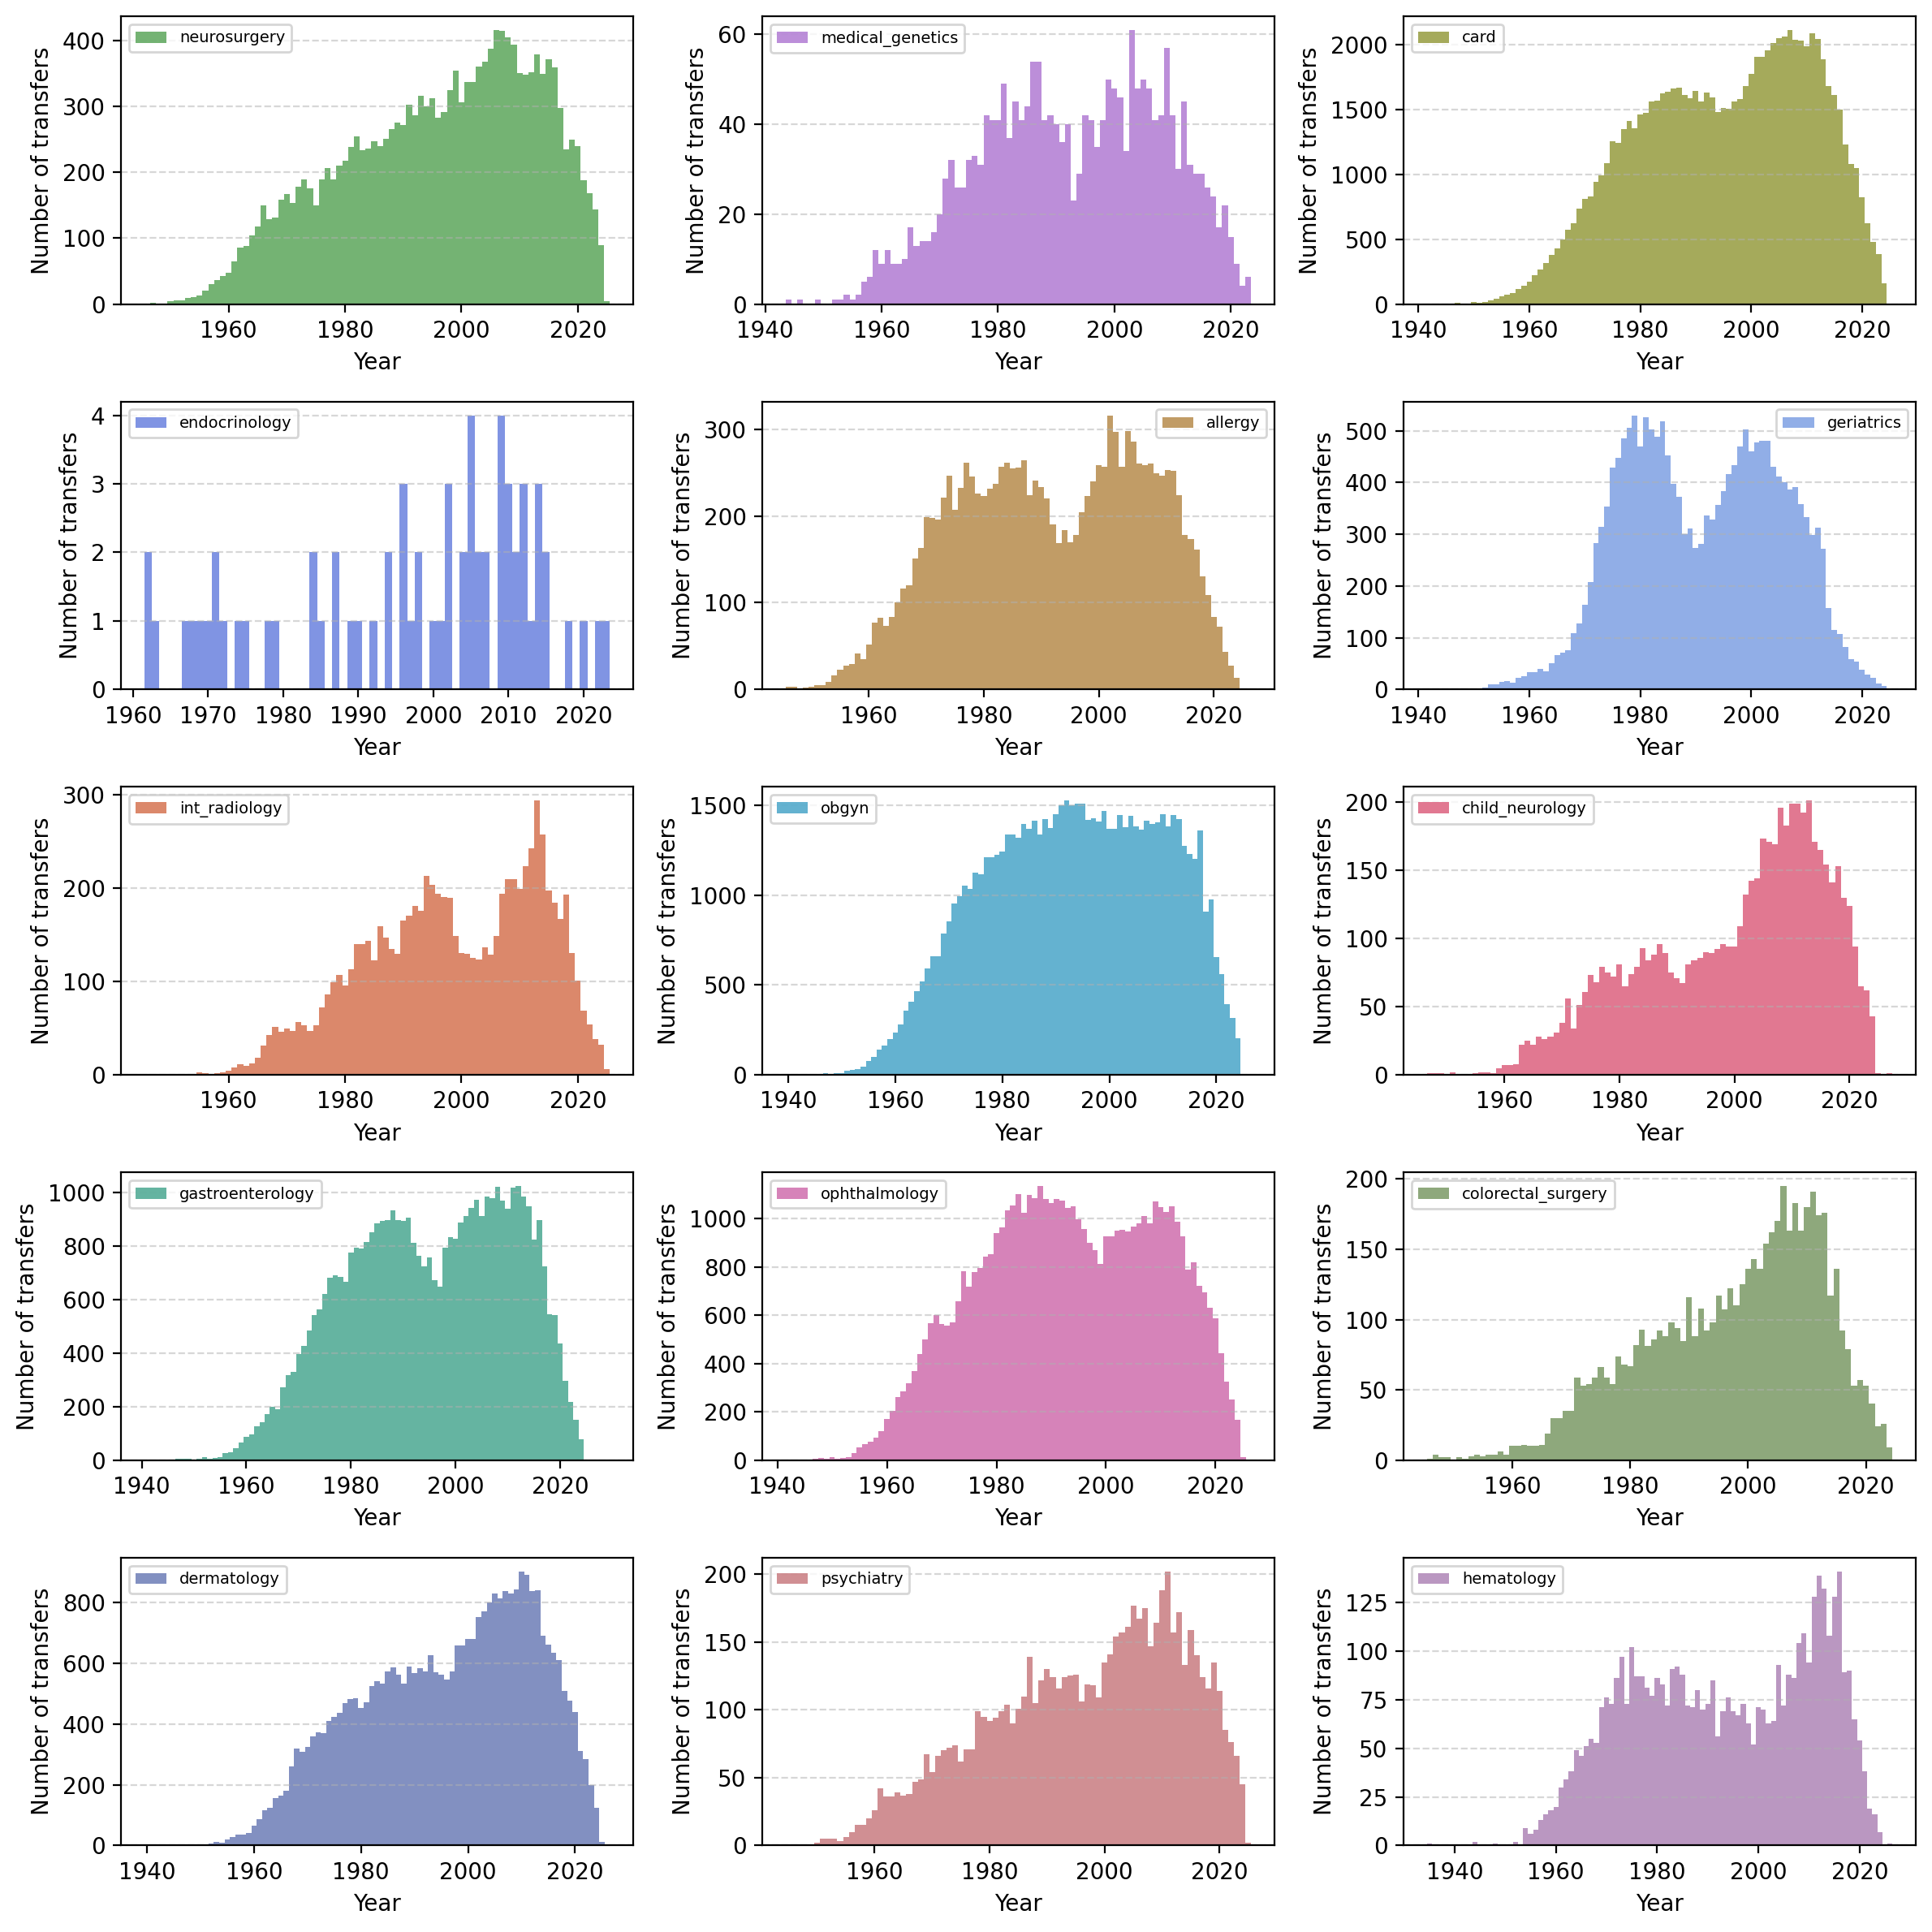

In [13]:
import matplotlib.cm as cm
fig, ax = plt.subplots(5,3,figsize=(12,12),dpi=200)

bin_size = 1
cols = ["#51a050",
"#ab72d0",
"#8f9532",
"#6079dc",
"#b28340",
"#769ae1",
"#d26a46",
"#3d9fc5",
"#da5676",
"#3fa18a",
"#cc64a8",
"#72925b",
"#6374b2",
"#c57378",
"#a97db2"]

for i, folder in enumerate(folders):
    tdf = tdf_dict[folder]
    tdf['time_elapsed'] = tdf['timestamp'] - tdf['timestamp'].min()
    tdf["time_bin"] = (tdf['time_elapsed'] // bin_size) * bin_size
    aggregate_counts = tdf["time_bin"].value_counts().sort_index()
    ax[i//3, i%3].bar(aggregate_counts.index + tdf['timestamp'].min(), aggregate_counts.values, width=bin_size, color=cols[i], alpha=0.8, label=folder)

    ax[i//3, i%3].grid(axis="y", linestyle="--", alpha=0.5)

    start_time = aggregate_counts.index.min()
    end_time = aggregate_counts.index.max()

    # ax[i//3, i%3].set_title("Transfers observed at %.0f year intervals"%(bin_size))
    ax[i//3, i%3].set_xlabel("Year")
    ax[i//3, i%3].set_ylabel("Number of transfers")
    ax[i//3, i%3].legend(fontsize=7)

plt.tight_layout()

plt.savefig('../figs/transfer_counts.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/transfer_counts.pdf', dpi=425, bbox_inches='tight')

### Creating temporal graph snapshots 

In [45]:
def temporal_network_from_data(
    data,
    aggregation="all",
    interval_size=1,
    time_window=None,
    custom_slices=None,
    directed=False,
    multigraph=False,
    column_names=None
):
    """
    Convert temporal edge data into NetworkX graph objects with flexible temporal aggregation.

    This function processes temporal edge data (provided as a DataFrame, CSV file, or NumPy array)
    to create NetworkX graphs. It supports various temporal aggregation methods, including grouping
    by fixed intervals, custom time slices, or a single aggregated graph for all data.

    Parameters:
    ----------
    data : pd.DataFrame, str, or np.ndarray
        Input temporal edge data. Can be:
        - A Pandas DataFrame with required columns: 'node_i', 'node_j', 'timestamp'.
        - A file path to a CSV file (requires `column_names` to be specified).
        - A NumPy array with columns matching the required structure (requires `column_names`).

    aggregation : str, optional
        Temporal aggregation method. Options are:
        - 'interval': Group data into fixed time intervals (specified by `interval_size`).
        - 'custom': Group data based on custom time slices (specified by `custom_slices`).
        - 'all': Aggregate all data into a single graph.
        Default is 'all'.

    interval_size : int, optional
        Size of the time intervals (in seconds) for 'interval' aggregation. Default is 1.

    time_window : tuple, optional
        A tuple `(start, stop)` to filter timestamps within a specific range (in seconds).
        Default is None, which includes all timestamps.

    custom_slices : list, optional
        List of custom slice sizes (in seconds) for 'custom' aggregation. For example, [3600, 7200]
        would create two time bins of 1 hour and 2 hours, respectively. Default is None.

    directed : bool, optional
        If True, creates directed graphs (DiGraph or MultiDiGraph). Default is False.

    multigraph : bool, optional
        If True, creates MultiGraphs or MultiDiGraphs to allow parallel edges. If False,
        standard Graph or DiGraph objects are created, and weights are aggregated. Default is False.

    column_names : list, optional
        Required when `data` is a CSV file or NumPy array. Specifies the column names as:
        ['node_i', 'node_j', 'timestamp', (optional) 'weight'].

    Returns:
    -------
    dict or networkx.Graph
        - If data is aggregated into multiple time bins (e.g., 'interval' or 'custom'), returns a
          dictionary where keys are time bins and values are NetworkX graph objects.
        - If data is aggregated into a single graph (e.g., 'all'), returns a single NetworkX graph.

    Raises:
    ------
    ValueError
        - If required columns ('node_i', 'node_j', 'timestamp') are missing.
        - If `custom_slices` is not provided for 'custom' aggregation.
        - If `column_names` is not provided when input data is a CSV file or NumPy array.

    TypeError
        - If input data is not a Pandas DataFrame, a CSV file path, or a NumPy array.

    Examples:
    --------
    1. Aggregating into a single graph:
        >>> G_agg = temporal_network_from_data(data, aggregation="all")

    2. Aggregating into 1-hour intervals:
        >>> G_interval = temporal_network_from_data(data, aggregation="interval", interval_size=3600)

    3. Using custom time slices:
        >>> G_custom = temporal_network_from_data(data, aggregation="custom", custom_slices=[3600, 7200])

    4. Handling a CSV file:
        >>> G_csv = temporal_network_from_data("edges.csv",
                                               column_names=["node_i","node_j","timestamp","weight"])

    Notes:
    -----
    - The 'weight' column, if present, is aggregated for standard graphs (not MultiGraphs).
    - The timestamp column must be numeric and represents time in seconds.
    """

    # Handle data input
    if isinstance(data, pd.DataFrame):
        df = data
    elif isinstance(data, str):  # CSV file path
        if column_names is None:
            raise ValueError("Column names must be provided when reading from a CSV file.")
        df = pd.read_csv(data, names=column_names)
    elif isinstance(data, np.ndarray):  # NumPy array
        if column_names is None:
            raise ValueError("Column names must be provided for a NumPy array.")
        df = pd.DataFrame(data, columns=column_names)
    else:
        raise TypeError("Input data must be a Pandas DataFrame, a CSV file path, or a NumPy array.")
    
    # Check required columns
    required_columns = {"node_u", "node_v", "time_elapsed"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Input data must contain {required_columns} columns.")
    
    # Filter by time window
    if time_window:
        start, stop = time_window
        df = df[(df["time_elapsed"] >= start) & (df["time_elapsed"] <= stop)]
    
    # Determine time bins
    if aggregation == "interval":
        df["time_bin"] = (df["time_elapsed"] // interval_size) * interval_size
    elif aggregation == "custom":
        if not custom_slices:
            raise ValueError("Custom slices must be provided for 'custom' aggregation.")
        time_bins = []
        current_start = df["time_elapsed"].min()
        for slice_size in custom_slices:
            current_end = current_start + slice_size
            time_bins.append((current_start, current_end))
            current_start = current_end
        
        # Assign rows to custom time bins
        def assign_to_custom_bin(ts):
            for i, (start, end) in enumerate(time_bins):
                if start <= ts < end:
                    return i
            return None  # Outside custom slices
        
        df["time_bin"] = df["time_elapsed"].apply(assign_to_custom_bin)
        df = df[df["time_bin"].notnull()]  # Remove rows outside custom slices
    elif aggregation == "all":
        df["time_bin"] = "all"  # Single graph for all data
    else:
        raise ValueError(f"Unsupported aggregation type: {aggregation}")
    
    # Group by time bins and create graphs
    graphs = {}
    for time_bin, group in df.groupby("time_bin"):
        # Determine graph type
        if multigraph:
            G = nx.MultiDiGraph() if directed else nx.MultiGraph()
        else:
            G = nx.DiGraph() if directed else nx.Graph()
        
        # Aggregate weights if multigraph is False
        if not multigraph:
            edge_weights = (
                group.groupby(["node_u", "node_v"])
                .agg(weight=("weight", "sum") if "weight" in group.columns else ("time_elapsed", "size"))
                .reset_index()
            )
            for _, row in edge_weights.iterrows():
                G.add_edge(row["node_u"], row["node_v"], weight=row["weight"])
        else:  # Add edges directly without aggregation
            for _, row in group.iterrows():
                G.add_edge(
                    row["node_u"], 
                    row["node_v"], 
                    weight=row.get("weight", 1), 
                    time_elapsed=row["time_elapsed"]
                )
        
        graphs[time_bin] = G
    
    # Return a single graph if no aggregation
    if aggregation == "all" or (aggregation == "custom" and len(graphs) == 1):
        return graphs["all"]

    return graphs


In [15]:
print(len(tdf_dict['card']['node_u'].unique()))
print(len(tdf_dict['card']['node_v'].unique()))

3339
2633


In [16]:
def get_binning(data, num_bins=50, is_pmf=False, log_binning=False, threshold=0):
    """
    Bins the input data and calculates the probability mass function (PMF) or 
    probability density function (PDF) over the bins. Supports both linear and 
    logarithmic binning.

    Parameters
    ----------
    data : array-like
        The data to be binned, typically a list or numpy array of values.
    num_bins : int, optional
        The number of bins to use for binning the data (default is 15).
    is_pmf : bool, optional
        If True, computes the probability mass function (PMF) by normalizing 
        histogram counts to sum to 1. If False, computes the probability density 
        function (PDF) by normalizing the density of the bins (default is True).
    log_binning : bool, optional
        If True, uses logarithmic binning with log-spaced bins. If False, uses 
        linear binning (default is False).
    threshold : float, optional
        Only values greater than `threshold` will be included in the binning, 
        allowing for the removal of isolated nodes or outliers (default is 0).
    
    Returns
    -------
    x : numpy.ndarray
        The bin centers, adjusted to be the midpoint of each bin.
    p : numpy.ndarray
        The computed PMF or PDF values for each bin.
    
    Notes
    -----
    This function removes values below a specified threshold, then defines 
    bin edges based on the specified binning method (linear or logarithmic). 
    It calculates either the PMF or PDF based on `is_pmf`.
    """
    
    # Filter out isolated nodes or low values by removing data below threshold
    values = list(filter(lambda x: x > threshold, data))
    if len(values) != len(data):
        print("%s isolated nodes have been removed" % (len(data) - len(values)))

    # Define the range for binning (support of the distribution)
    lower_bound = min(values)
    upper_bound = max(values)

    # Define bin edges based on binning type (logarithmic or linear)
    if log_binning:
        # Use log-spaced bins by taking the log of the bounds
        lower_bound = np.log10(lower_bound)
        upper_bound = np.log10(upper_bound)
        bin_edges = np.logspace(lower_bound, upper_bound, num_bins + 1, base=10)
    else:
        # Use linearly spaced bins
        bin_edges = np.linspace(lower_bound, upper_bound, num_bins + 1)

    # Calculate histogram based on chosen binning method
    if is_pmf:
        # Calculate PMF: normalized counts of data in each bin
        y, _ = np.histogram(values, bins=bin_edges, density=False)
        p = y / y.sum()  # Normalize to get probabilities
    else:
        # Calculate PDF: normalized density of data in each bin
        p, _ = np.histogram(values, bins=bin_edges, density=True)

    # Compute bin centers (midpoints) to represent each bin
    x = bin_edges[1:] - np.diff(bin_edges) / 2  # Bin centers for plotting

    # Remove bins with zero probability to avoid plotting/display issues
    x = x[p > 0]
    p = p[p > 0]

    return x, p

In [72]:
tdf_dict['card']

,node_u,node_v,timestamp,time_elapsed,time_bin
0,Massachusetts General Hospital,Brandeis University,1997.0,55.0,55.0
1,Brigham and Women's Hospital,Massachusetts General Hospital,1993.0,51.0,51.0
2,Albert Einstein College of Medicine,Brigham and Women's Hospital,1991.0,49.0,49.0
3,Albert Einstein College of Medicine,Albert Einstein College of Medicine,1991.0,49.0,49.0
4,Wesleyan Universtity,Albert Einstein College of Medicine,1982.0,40.0,40.0
...,...,...,...,...,...
86095,University of Pennsylvania Health System,Other Training,2013.0,71.0,71.0
86096,Icahn School of Medicine at Mount Sinai/Mount ...,University of Pennsylvania Health System,2008.0,66.0,66.0
86097,Central University of Venezuela,Icahn School of Medicine at Mount Sinai/Mount ...,2003.0,61.0,61.0
86098,Corewell Health East Beaumont (Royal Oak),Corewell Health East Beaumont (Royal Oak),1992.0,50.0,50.0


In [46]:
g_agg = temporal_network_from_data(
    data = tdf_dict['card'],
    aggregation="interval",
    interval_size=1,
    directed=True
)
g_agg

{0.0: <networkx.classes.digraph.DiGraph at 0x3185cc770>,
 1.0: <networkx.classes.digraph.DiGraph at 0x3185ce4e0>,
 2.0: <networkx.classes.digraph.DiGraph at 0x323b2c530>,
 3.0: <networkx.classes.digraph.DiGraph at 0x32f450260>,
 4.0: <networkx.classes.digraph.DiGraph at 0x3185fe450>,
 5.0: <networkx.classes.digraph.DiGraph at 0x31d600650>,
 6.0: <networkx.classes.digraph.DiGraph at 0x3184050d0>,
 7.0: <networkx.classes.digraph.DiGraph at 0x318461e20>,
 8.0: <networkx.classes.digraph.DiGraph at 0x31d602f60>,
 9.0: <networkx.classes.digraph.DiGraph at 0x3185cd220>,
 10.0: <networkx.classes.digraph.DiGraph at 0x31d1b3530>,
 11.0: <networkx.classes.digraph.DiGraph at 0x3183dbd70>,
 12.0: <networkx.classes.digraph.DiGraph at 0x332eb3980>,
 13.0: <networkx.classes.digraph.DiGraph at 0x32f4504d0>,
 14.0: <networkx.classes.digraph.DiGraph at 0x32f452900>,
 15.0: <networkx.classes.digraph.DiGraph at 0x31d1b18b0>,
 16.0: <networkx.classes.digraph.DiGraph at 0x32f451b20>,
 17.0: <networkx.classes

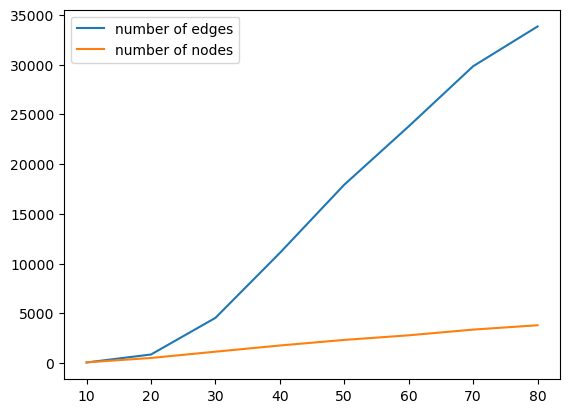

In [56]:
interval_sizes = [10, 20, 30, 40, 50, 60, 70, 80]
cols = plt.cm.viridis(np.linspace(0,1,1+len(interval_sizes)))[1:]
num_edges = []
num_nodes = []
for i,int_s in enumerate(interval_sizes):
    Gt_i = list(temporal_network_from_data(tdf, aggregation="interval", interval_size=int_s).values())[0]
    num_edges.append(Gt_i.number_of_edges())
    num_nodes.append(Gt_i.number_of_nodes())

plt.plot(interval_sizes, num_edges, label='number of edges')
plt.plot(interval_sizes, num_nodes, label='number of nodes')
plt.legend()
    

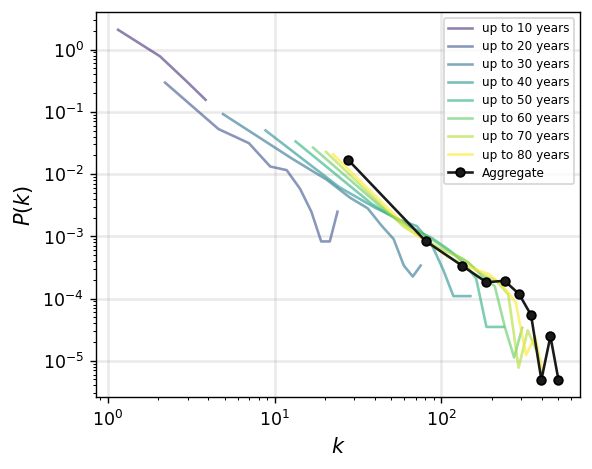

In [49]:
import matplotlib.pyplot as plt
import numpy as np
tdf = tdf_dict['card']
fig, ax = plt.subplots(1,1,figsize=(5,4),dpi=125)

G_agg = temporal_network_from_data(
    data = tdf_dict['card'],
    aggregation="all",
    directed=True
)

degrees = np.array(list(dict(G_agg.degree()).values()))
x_agg, y_agg = get_binning(degrees, num_bins=10)

# weights_agg = np.array(list(nx.get_edge_attributes(g_agg, 'weight').values()))
# xw_agg, yw_agg = get_binning(weights_agg, num_bins=20)

interval_sizes = [10, 20, 30, 40, 50, 60, 70, 80]
cols = plt.cm.viridis(np.linspace(0,1,1+len(interval_sizes)))[1:]
# colsw = plt.cm.magma(np.linspace(0,1,1+len(interval_sizes)))[:-1]
for i,int_s in enumerate(interval_sizes):
    Gt_i = list(temporal_network_from_data(tdf, aggregation="interval", interval_size=int_s).values())[0]
    degrees_ti = np.array(list(dict(Gt_i.degree()).values()))
    x_ti, y_ti = get_binning(degrees_ti, num_bins=10)
    ax.loglog(x_ti, y_ti, '-', color=cols[i], label='up to %i years'%(int_s),
              alpha=0.6)
    # weights_ti = np.array(list(nx.get_edge_attributes(Gt_i, 'weight').values()))
    # xw_ti, yw_ti = get_binning(weights_ti, num_bins=20)
    # ax[1].loglog(xw_ti, yw_ti, '-', color=colsw[i], label='up to %i day'%(i+1),
    #           alpha=0.6)
    
    
ax.loglog(x_agg, y_agg, '.-', color='.1', label='Aggregate', mec='.0', ms=10)
# ax[1].loglog(xw_agg, yw_agg, '.-', color='.1', label='Aggregate', mec='.0', ms=10)

ax.set_xlabel(r"$k$",fontsize='large')
ax.set_ylabel(r"$P(k)$",fontsize='large')
ax.legend(fontsize='x-small',loc='upper right')
ax.grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
# ax.set_title('SocioPatterns Degree Distribution')
# ax[1].set_xlabel(r"$w$",fontsize='large')
# ax[1].set_ylabel(r"$P(w)$",fontsize='large')
# ax[1].legend(fontsize='x-small',loc=1)
# ax[1].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
# ax[1].set_title('SocioPatterns Weights Distribution')

plt.savefig('../figs/cum_temp_degree_card.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/cum_temp_degree_card.pdf', dpi=425, bbox_inches='tight')



In [62]:
transitivity = []
density = []
num_edges = []
num_nodes = []
for t in g_agg:
    transitivity.append(nx.transitivity(g_agg[t]))
    density.append(nx.density(g_agg[t]))
    num_edges.append(g_agg[t].number_of_edges())
    num_nodes.append(g_agg[t].number_of_nodes())

In [63]:
transitivity

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.038461538461538464,
 0,
 0,
 0.043478260869565216,
 0,
 0,
 0.010309278350515464,
 0.0045871559633027525,
 0.014598540145985401,
 0.010101010101010102,
 0.019305019305019305,
 0.020370370370370372,
 0.018115942028985508,
 0.020161290322580645,
 0.014893617021276596,
 0.012479201331114808,
 0.013812154696132596,
 0.013745704467353952,
 0.015644555694618274,
 0.02040816326530612,
 0.01742627345844504,
 0.018651362984218076,
 0.01970108695652174,
 0.021212121212121213,
 0.018485915492957746,
 0.018217306441119064,
 0.02169926650366748,
 0.032981530343007916,
 0.024390243902439025,
 0.028554431885782272,
 0.02694235588972431,
 0.025522755227552277,
 0.02695800227014756,
 0.033012820512820513,
 0.027469316189362946,
 0.03132161955691368,
 0.03730272596843615,
 0.03807615230460922,
 0.0390915860014892,
 0.038306451612903226,
 0.030789825970548863,
 0.03400222965440357,
 0.03151157065484983,
 0.031016042780748664,
 0.04533261802575107

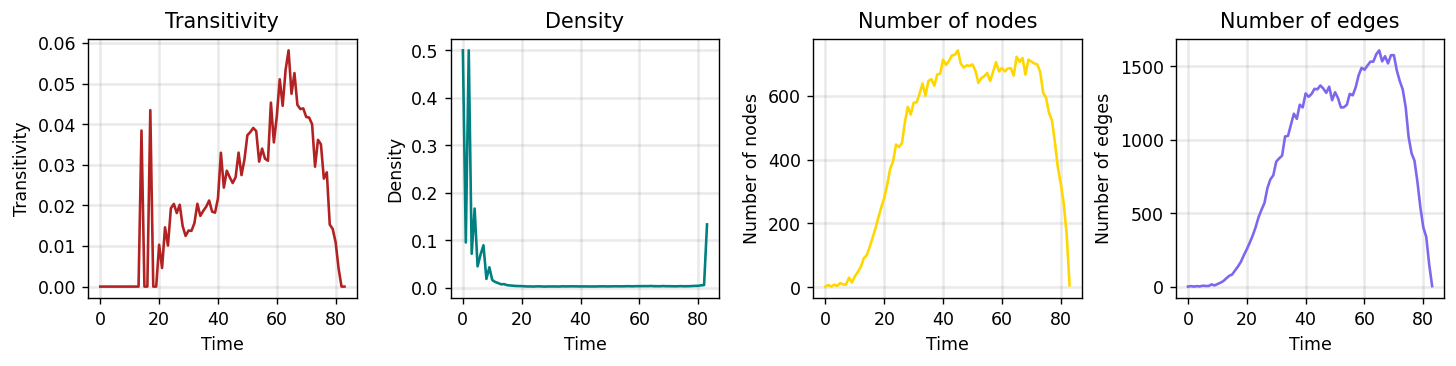

In [74]:
fig, ax = plt.subplots(1,4,figsize=(14,2.7),dpi=125)
ax[0].plot(g_agg.keys(),transitivity, color='firebrick')
ax[1].plot(g_agg.keys(),density, color='teal')
ax[2].plot(g_agg.keys(),num_nodes, color='gold')
ax[3].plot(g_agg.keys(),num_edges, color='mediumslateblue')
ax[0].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[1].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[2].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[3].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[0].set_title('Transitivity')
ax[1].set_title('Density')
ax[2].set_title('Number of nodes')
ax[3].set_title('Number of edges')
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[2].set_xlabel('Time')
ax[3].set_xlabel('Time')
ax[0].set_ylabel('Transitivity')
ax[1].set_ylabel('Density')
ax[2].set_ylabel('Number of nodes')
ax[3].set_ylabel('Number of edges')
plt.tight_layout
plt.subplots_adjust(wspace=0.35)